# DATA VISUALIZATION
## Load Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
import datetime
import pickle

pd.set_option('display.max_columns', None) # no truncate columns

In [2]:
#Environment settings
data_path_in = 'Data/input/'
data_path_out = 'Data/output/'

data_type = {
    'StoreID': 'uint16',
    'Date': str,
    'IsHoliday': bool,
    'IsOpen': bool,
    'HasPromotions': bool,
    'StoreType': 'category',
    'AssortmentType': 'category',
    'NearestCompetitor': 'uint32',
    'Region': 'category',
    'NumberOfCustomers': 'uint16',
    'NumberOfSales': 'uint16',
    'Region_AreaKM2': 'uint16',
    'Region_GDP': 'uint16',
    'Region_PopulationK': 'uint16',
    'CloudCover': 'float32',
    'Events': 'category',
    'Max_Dew_PointC': 'int8',
    'Max_Gust_SpeedKm_h': 'float32', # 'uint8'
    'Max_Humidity': 'uint8',
    'Max_Sea_Level_PressurehPa': 'uint16',
    'Max_TemperatureC': 'int8',
    'Max_VisibilityKm': 'float32', # 'uint8'
    'Max_Wind_SpeedKm_h': 'uint8',
    'Mean_Dew_PointC': 'int8',
    'Mean_Humidity': 'uint8',
    'Mean_Sea_Level_PressurehPa': 'uint16',
    'Mean_TemperatureC': 'int8',
    'Mean_VisibilityKm': 'float32', # 'uint8'
    'Mean_Wind_SpeedKm_h': 'uint8',
    'Min_Dew_PointC': 'int8',
    'Min_Humidity': 'uint8',
    'Min_Sea_Level_PressurehPa': 'uint16',
    'Min_TemperatureC': 'int8',
    'Min_VisibilitykM': 'float32', #'uint8'
    'Precipitationmm': 'float32',
    'WindDirDegrees': 'int16'
}

# load and serialize dataframes for later use in preprocessing notebook
df = {}
for ds_name in ['train', 'test']:
    df[ds_name] = pd.read_csv(data_path_in+ds_name+'.csv', dtype=data_type, parse_dates=["Date"], dayfirst=True)
    with open(data_path_out+ds_name+'_dv.obj', 'wb') as file:
        pickle.dump(df, file)

train = df['train']
test = df['test']

In [3]:
print("Train set has shape {}.\nTest set has shape {}" .format(train.shape, test.shape))

Train set has shape (523021, 36).
Test set has shape (45689, 34)


## Combining train & test data

In [4]:
X = train.copy()
X = X.drop(columns=['NumberOfCustomers', 'NumberOfSales'], axis=1)
y = train.loc[:, 'NumberOfCustomers':'NumberOfSales']

all_data = pd.concat([X, test], axis=0).reset_index()

#to restore the original column order
all_data = all_data[list(test.columns.values)]
all_data.head(10)


,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Events,Max_Dew_PointC,Max_Gust_SpeedKm_h,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_VisibilityKm,Max_Wind_SpeedKm_h,Mean_Dew_PointC,Mean_Humidity,Mean_Sea_Level_PressurehPa,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
0,1000,2016-03-01,False,True,False,Hyper Market,General,326,7,9643,17130,2770,8.0,Rain-Snow,1,NaN,100,1032,2,19.0,21,-1,82,1030,1,11.0,16,-2,70,1029,1,6.0,0.00,23
1,1000,2016-03-02,False,True,False,Hyper Market,General,326,7,9643,17130,2770,8.0,Snow,0,NaN,87,1030,5,23.0,16,-1,73,1027,3,13.0,10,-2,58,1025,1,10.0,0.00,56
2,1000,2016-03-04,False,True,False,Hyper Market,General,326,7,9643,17130,2770,8.0,Rain,0,NaN,81,1026,4,31.0,23,-1,71,1024,3,11.0,10,-3,55,1023,2,8.0,0.00,22
3,1000,2016-03-05,False,True,False,Hyper Market,General,326,7,9643,17130,2770,6.0,NaN,-3,NaN,80,1027,8,31.0,19,-4,56,1024,3,15.0,10,-6,25,1022,-1,10.0,0.00,108
4,1000,2016-03-06,False,False,False,Hyper Market,General,326,7,9643,17130,2770,6.0,NaN,0,NaN,93,1025,7,31.0,16,-3,75,1023,1,12.0,5,-6,48,1022,-5,5.0,0.00,46
5,1000,2016-03-07,False,True,True,Hyper Market,General,326,7,9643,17130,2770,NaN,NaN,-2,NaN,93,1024,11,31.0,24,-3,65,1020,4,22.0,11,-4,26,1016,-2,16.0,0.00,68
6,1000,2016-03-08,False,True,True,Hyper Market,General,326,7,9643,17130,2770,NaN,NaN,-1,NaN,87,1017,13,26.0,14,-2,60,1012,6,21.0,8,-4,24,1008,-2,18.0,0.00,62
7,1000,2016-03-09,False,True,True,Hyper Market,General,326,7,9643,17130,2770,NaN,NaN,2,NaN,93,1009,15,26.0,16,-1,59,1004,7,22.0,10,-2,25,1000,-1,13.0,0.00,53
8,1000,2016-03-10,False,True,True,Hyper Market,General,326,7,9643,17130,2770,7.0,Rain,8,NaN,87,1002,16,26.0,13,2,55,1000,11,14.0,6,0,28,999,6,7.0,0.00,54
9,1000,2016-03-11,False,True,True,Hyper Market,General,326,7,9643,17130,2770,7.0,Rain,8,NaN,93,1002,17,14.0,14,7,71,1000,12,9.0,11,5,37,998,7,6.0,0.51,30


## 1. Numerical features

In [5]:
numeric_features = all_data.select_dtypes(include=[np.number])

print("There are {} numeric features ({:.2f}% of total) ".format(numeric_features.shape[1],
                                                                 (numeric_features.shape[1]/
                                                                  all_data.shape[1])*100))

There are 26 numeric features (76.47% of total) 


In [6]:
all_data.describe()

,StoreID,NearestCompetitor,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Max_Dew_PointC,Max_Gust_SpeedKm_h,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_VisibilityKm,Max_Wind_SpeedKm_h,Mean_Dew_PointC,Mean_Humidity,Mean_Sea_Level_PressurehPa,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,519111.000000,568710.000000,124325.000000,568710.000000,568710.000000,568710.000000,554751.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,554751.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,554751.000000,568710.000000,568710.000000
mean,1373.957616,7999.119534,12448.404758,14057.774367,3867.832217,5.560682,8.196299,48.544918,93.401607,1018.554787,14.250695,23.649191,22.405618,5.872554,74.302602,1015.373630,10.011000,12.250188,11.784913,3.340256,50.406260,1012.401630,5.852888,7.290294,0.780502,171.945909
std,216.381498,11529.083651,9197.663508,2753.553082,2814.035417,1.717195,5.905485,13.392765,7.622350,8.128224,7.997932,9.134519,8.958702,5.830991,12.977769,8.443824,6.883573,5.017721,5.878919,5.895683,19.309611,8.925047,6.238434,4.929762,2.551008,102.741075
min,1000.000000,47.000000,344.000000,9893.000000,816.000000,0.000000,-14.000000,21.000000,44.000000,976.000000,-11.000000,0.000000,3.000000,-15.000000,30.000000,974.000000,-13.000000,0.000000,2.000000,-18.000000,8.000000,970.000000,-15.000000,0.000000,0.000000,-1.000000
25%,1187.000000,1057.000000,7215.000000,11849.000000,1293.000000,5.000000,4.000000,39.000000,89.000000,1013.000000,8.000000,11.000000,16.000000,2.000000,65.000000,1010.000000,4.000000,10.000000,8.000000,-1.000000,35.000000,1007.000000,1.000000,3.000000,0.000000,75.000000
50%,1373.000000,3321.000000,9643.000000,15017.000000,2770.000000,6.000000,8.000000,47.000000,94.000000,1019.000000,14.000000,31.000000,21.000000,6.000000,76.000000,1016.000000,10.000000,11.000000,11.000000,3.000000,50.000000,1013.000000,6.000000,8.000000,0.000000,194.000000
75%,1561.000000,9673.000000,15566.000000,15931.000000,5727.000000,7.000000,13.000000,55.000000,100.000000,1024.000000,20.000000,31.000000,27.000000,11.000000,84.000000,1021.000000,16.000000,14.000000,14.000000,8.000000,65.000000,1018.000000,11.000000,10.000000,0.250000,254.000000
max,1748.000000,85070.000000,32221.000000,23931.000000,8146.000000,8.000000,23.000000,106.000000,100.000000,1043.000000,37.000000,31.000000,101.000000,20.000000,100.000000,1040.000000,30.000000,31.000000,53.000000,18.000000,100.000000,1038.000000,24.000000,31.000000,58.930000,360.000000


### Date manipulation

In [7]:
all_data.Date.head()

0   2016-03-01
1   2016-03-02
2   2016-03-04
3   2016-03-05
4   2016-03-06
Name: Date, dtype: datetime64[ns]

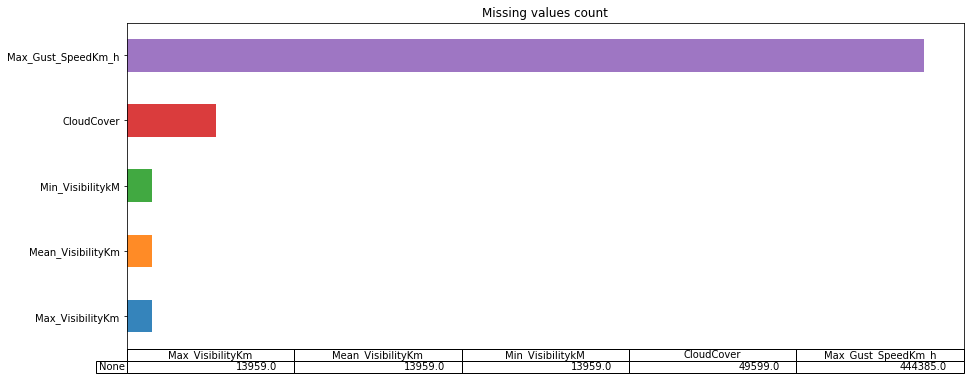

In [8]:
# Missing values
plt.figure(figsize=(15,6))
rows_length = numeric_features.shape[0]
numeric_nan_length = numeric_features.isna().sum().where(lambda x : x > 0).dropna()
numeric_nan_length = numeric_nan_length.sort_values()
ax = numeric_nan_length \
.plot(kind='barh', alpha=0.9, title='Missing values count', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

### Max_Gust_SpeedKm_h

In [9]:
all_data = all_data.drop('Max_Gust_SpeedKm_h', axis=1)
all_data.shape

(568710, 33)

### CloudCover & Visibility

In [10]:
nan_index = all_data[all_data['CloudCover'].isnull()].index.tolist()
# for i in nan_index:
#     curr_date = all_data.loc[i,'Date']
#     curr_region = all_data.loc[i,'Region']
#     regional_stores = all_data[(all_data.Date == curr_date) & (all_data.Region == curr_region)]
#     curr_mode = regional_stores['CloudCover'].mode()


# 

### Time - sales visualization

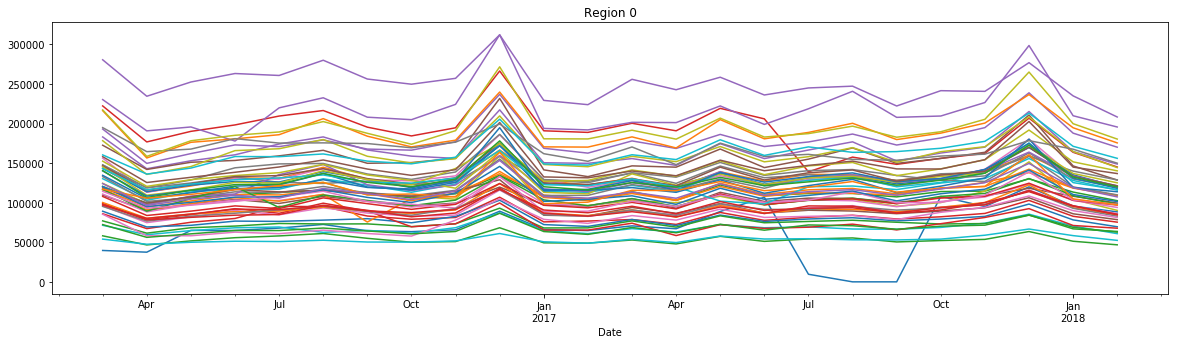

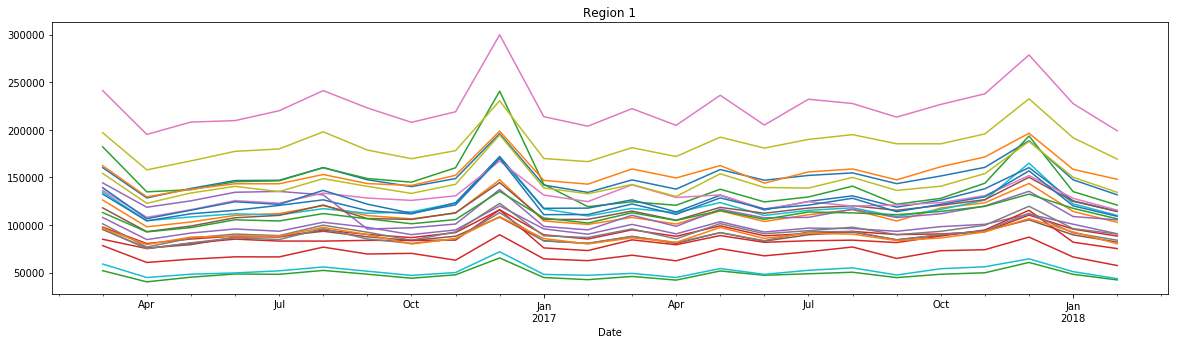

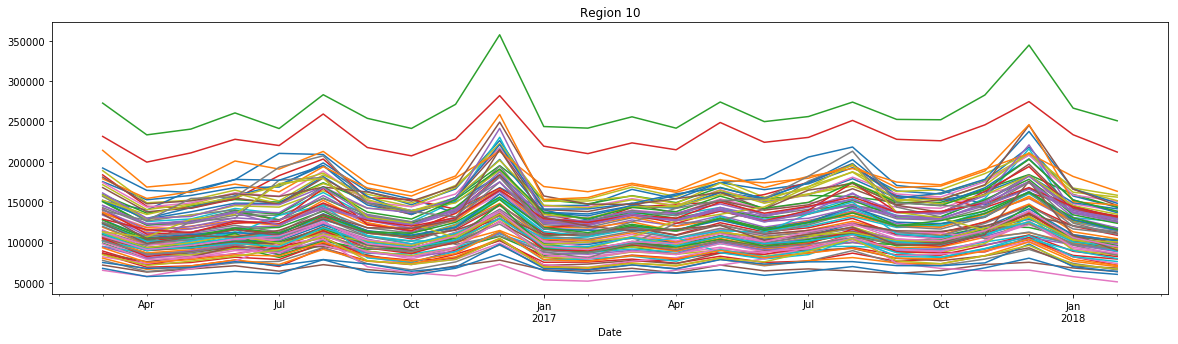

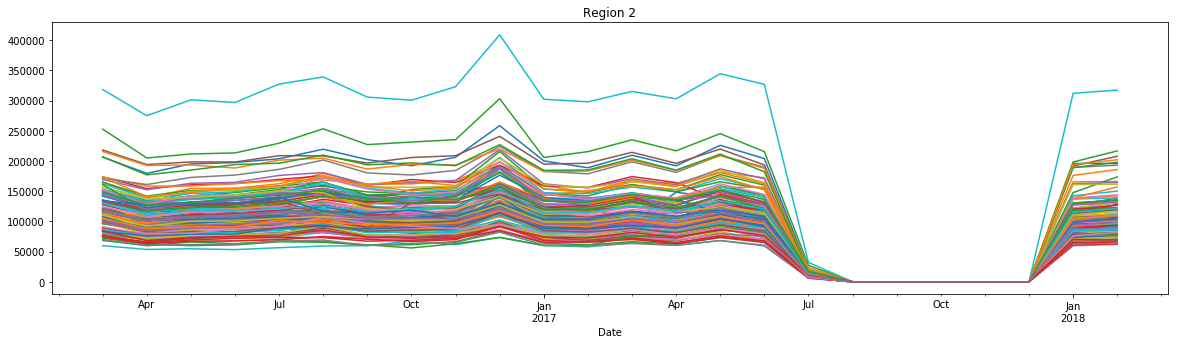

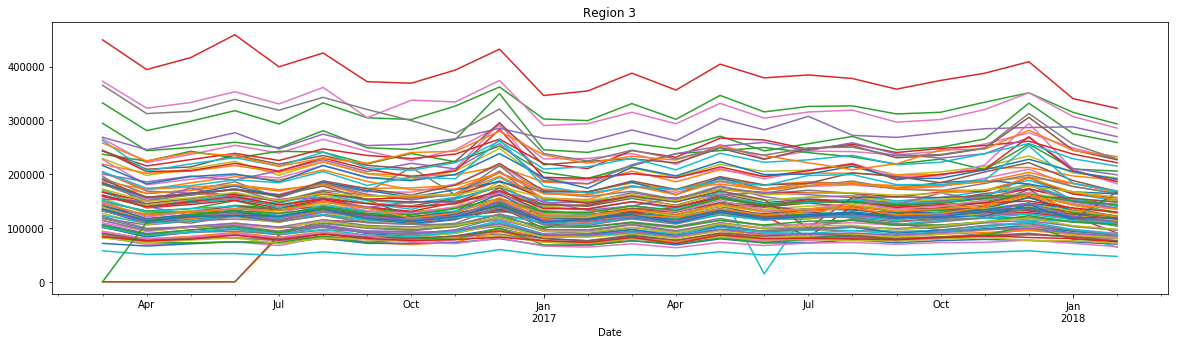

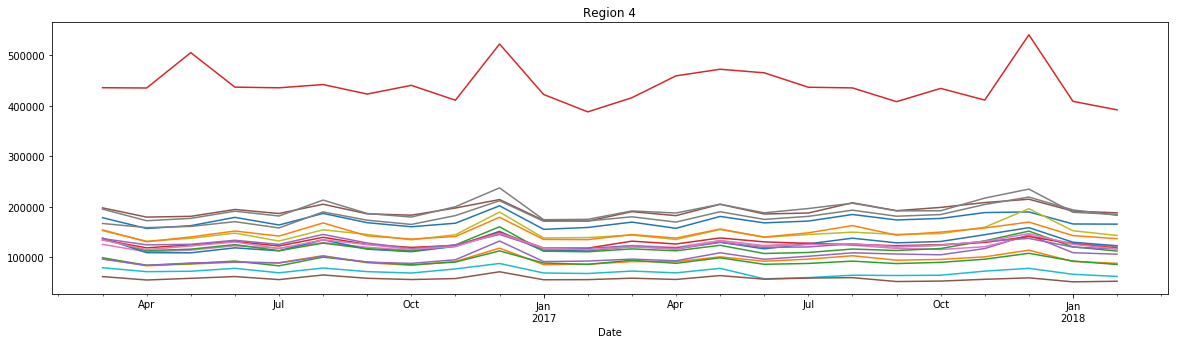

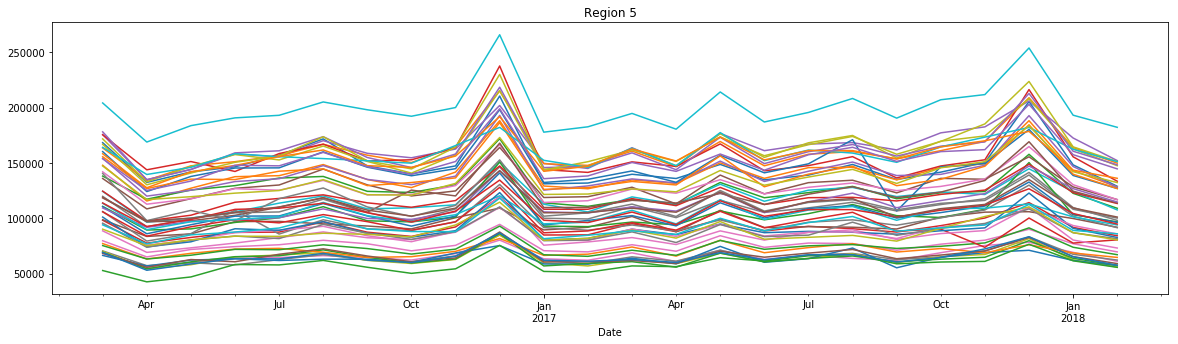

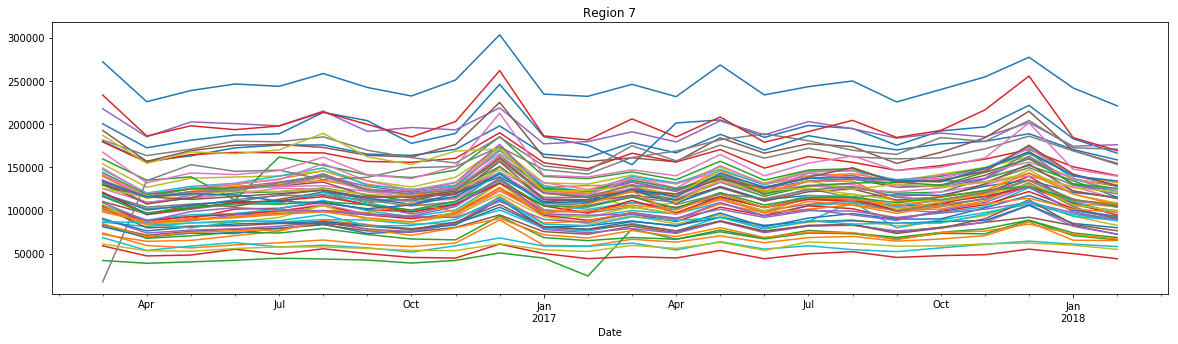

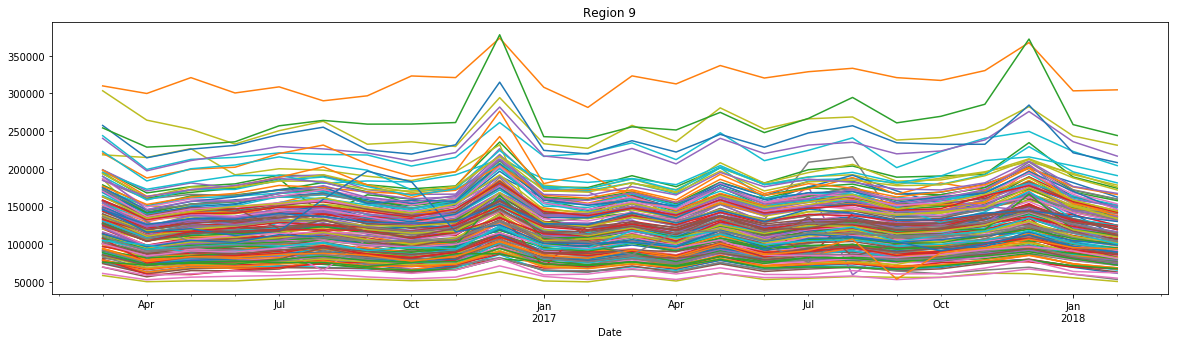

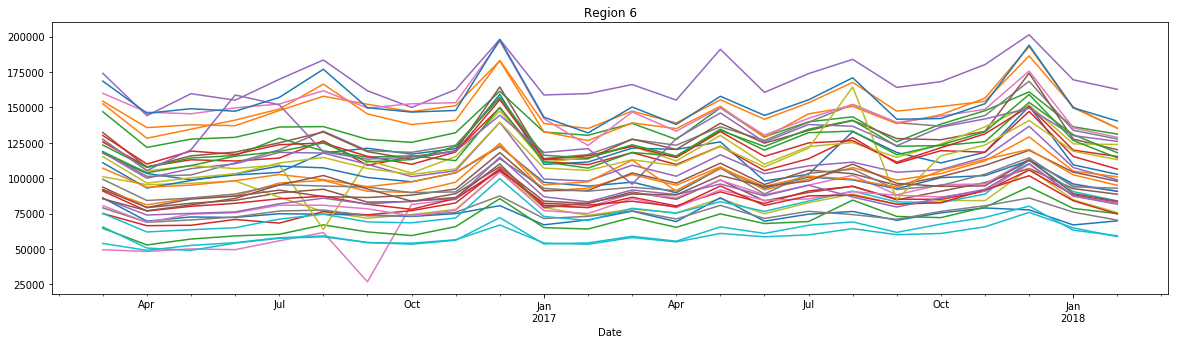

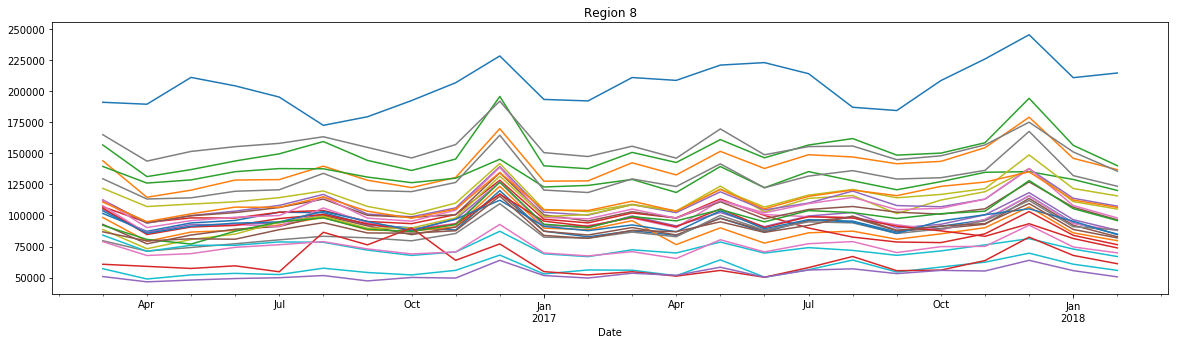

In [11]:
# NumberOfSales per region in a monthly basis
for regionID, region in train.groupby('Region'):
    for storeID, store in region.groupby('StoreID'):
        ts = pd.Series(store['NumberOfSales'].values, index=store['Date'])
        ts.resample('M').sum().plot(figsize=(20,5), title='Region {}'.format(regionID))
    plt.show()